Notebook pour calculer les Excess Waiting Time.
Tout d'abord on a besoin des packages pour Cluster

In [1]:
import gtfs_functions as gtfs
import matplotlib
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import random
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# cluster visualizer
#%matplotlib inline
#from yellowbrick.cluster import KElbowVisualizer 

# sklearn kmeans
from sklearn.metrics.cluster import contingency_matrix

# pyclustering kmeans
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.kmedians import kmedians
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture

import csv

In [2]:
#We import the schedule

path_gtfs ='C:/Users/Maison/Documents/INFO-H423/Projet Data Mining/GTFS3sep/gtfs3sept.zip'

routes, stops, stop_times, trips, shapes = gtfs.import_gtfs(path_gtfs,busiest_date=False)

In [3]:
#We import the calendar by hand 

calendardf = pd.read_table('calendar.txt',sep=',')          #export the calendar file into data frame
calendarDatesdf = pd.read_table('calendar_dates.txt',sep=',')  #also export the exceptions

In [24]:
calendarDatesdf[calendarDatesdf['exception_type']==2].head(20)

,service_id,date,exception_type
6,233898050,20210830,2
12,235811052,20210830,2
13,237231071,20210902,2
14,237231071,20210903,2
15,237231071,20210906,2
16,237231071,20210907,2
17,237231071,20210909,2
18,237231071,20210910,2
19,237231071,20210913,2
20,237231071,20210914,2


In [26]:
calendardf[calendardf['service_id']==233898050]

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
48,233898050,1,1,1,1,1,0,0,20210823,20210831


In [4]:
def FromDayToService(date):
    '''Determine all the service_id concerned by a date, given in the format date=('20210907','tuesday')
        it first take a look at every regular service_id then examine the exceptions. 
        Returns a list of service_id of type string'''

    ListServiceId=[]
    for i in range(len(calendardf)):
        startdate,endate=calendardf.iloc[i,[8,9]]
        if int(date[0]) in range(int(startdate),int(endate)+1):
            if calendardf.loc[i,date[1]]==1:
                #It appends every service_id which contains the date, and for which there is a '1'
                # under right day in the week
                ListServiceId.append(str(calendardf.iloc[i,0]))     

    #Now we have to take a look a the exceptions
    #We selections all the exceptions in calendarDatesdf that concerns the date in the input
    ModifServiceId= calendarDatesdf[calendarDatesdf['date']==int(date[0])][['service_id','exception_type']]
    #print('Number of service_id involved in modifications: '+ str(len(ModifServiceId)))
    #for every modif we check the kind of exception
    for modif in ModifServiceId.iterrows():  
        service = str(modif[1]['service_id'])
        exception = modif[1]['exception_type']
        if exception == 1:
            #if the exception is 1, it means that we should change to a 1 the cell related to the date in
            # input, in the row equal to service in calendar
            ListServiceId.append(service)
            #print('ServiceId: '+str(service)+' correclty added' )
        elif (exception == 2) & (service in ListServiceId):
            #if the exception is 2, it means that we should change to a 0 the cell related to the date in
            # input, in the row equal to service in calendar
            #Since this service_id must have been selected in the first loop (in Calendar), we need to remove it
            ListServiceId.remove(service)
            #print('ServiceId: '+str(service)+' correclty removed' )
        elif (exception == 2) & (service not in ListServiceId):
            #if the exception is 2 but we haven't found the service id in the first loop, this is weird
            #In principle this should not happend, but we're never too carefull
            print('Warning : exception 2 but no service_id = ' +service+ ' found in calendar')
    return (ListServiceId)

def FromLineIdtoRouteId(LineId):
    
    '''Takes a lineid in argument a returns the correspondent routeid, since stop_times only 
        contains route_id'''

    routeId = routes[routes['route_short_name']==LineId]['route_id'].iloc[0]
    return routeId

def ScheduledTime(date,routeid,stopId):

    '''Takes a triplet (date,routeid,stopId) with date in the format date=('20210907','tuesday')
        and returns the schedule for that triplet. The schedule is composed as follows: if we are in a period of
        punctuality then returns the (arrivaltime,true), and if we are in regularity, 
        returns (TimeOfWaitFromPreviousVehicle,False), all in one list '''

    ListOfService = pd.Series(FromDayToService(date))  #List of service_id tha apply for that day
    #RouteId = FromLineIdtoRouteId(lineId)               #We need the routeid to seek in the GTFS
    #We select the relevant rows in GTFS stop_times
    Scheduledf = stop_times[(stop_times['stop_id']==stopId)&(stop_times['route_id']==routeid)&(stop_times['service_id'].isin(ListOfService))].sort_values('arrival_time')
    ArrivalTime = Scheduledf['arrival_time'].values
    #print('Number of service_id involved: '+ str(len(ListOfService)))
    #We compute every wainting time to determine punctuality of regularity (< or > 720 s)
    #Schedule = list(ArrivalTime[1:]-ArrivalTime[:-1])
    IntervalTime = list(ArrivalTime[1:]-ArrivalTime[:-1])
    #Schedule.insert(0,ArrivalTime[0])
    #True if punctuality, False if regularity
    Punctuality = np.array(IntervalTime)>720 
    #Ultimately, if we are a punctuality, we want the arrival time and if we are in regularity, we want the 
    #time bewteen two vehicles
    for i,punctuality in enumerate(Punctuality):
        if punctuality:
            if (0<i<(len(Punctuality)-1)):
                if ~(Punctuality[i-1]) & ~(Punctuality[i+1]):
                    Punctuality[i]=False
            else:
                IntervalTime[i]=ArrivalTime[i]
 
    #Schedule = list(zip(Schedule,Punctuality))
    #The format is a list of tuples
    if len(IntervalTime)!=len(ArrivalTime[:-1]):
        print('Attention: la longueur de Schedule et ArrivalTime ne match pas dans ScheduledTime ')
    return IntervalTime,Punctuality,ArrivalTime[:-1]

def RouteIdToLineId(routeId):

    '''Takes a routeid in argument a returns the correspondent lineid'''

    lineId = routes[routes['route_id']==routeId]['route_short_name'].iloc[0]
    return lineId

def TroncatedScheduleRegularity(date,routeid,stopId):

    '''Takes a triplet (date,routeid,stopId) in the format date=('20210907','tuesday') and returns the IntervalTime 
        and ArrivalTime cleared from the ponctuality point'''
    ScheduleNonCleared = ScheduledTime(date,routeid,stopId)
    TroncatedInterval = [intervaltime for i,intervaltime in enumerate(ScheduleNonCleared[0]) if not(ScheduleNonCleared[1][i])]
    TroncatedArrival = [arrivaltime for i,arrivaltime in enumerate(ScheduleNonCleared[2]) if not(ScheduleNonCleared[1][i])]
    if len(TroncatedInterval)!= len(TroncatedArrival):
        print('Attention: la longueur de TroncatedInterval et TroncatedArrival ne match pas dans TroncatedScheduleRegularity ')
    return TroncatedInterval,TroncatedArrival

Bellow is the cell that compute the middle stop from a line in a specific direction, not really relevant now

In [5]:
StopTimesGroupTrip = stop_times.groupby('trip_id')[['stop_sequence']].mean().round()
StopTimesGroupTrip['stop_sequence']=StopTimesGroupTrip['stop_sequence'].astype(int)

StopTimesOnlyMeanSeq = pd.merge(stop_times, StopTimesGroupTrip, how='right', on= ['trip_id','stop_sequence'])
StopTimesOnlyMeanSeq = StopTimesOnlyMeanSeq[['route_id','stop_sequence','stop_id','direction_id']]
DicOfMiddleStop={}

for route in StopTimesOnlyMeanSeq['route_id'].unique():
    StopTimeMeanSeqRoute = StopTimesOnlyMeanSeq[StopTimesOnlyMeanSeq['route_id']==route]
    directionIds = StopTimeMeanSeqRoute['direction_id'].unique()
    for direction in directionIds:
        #Ici je prends la première valeure que je trouve qui a la bonne route et direction
        # car il peut y avoir plusieurs candidat Middle stop pour chaque (ligne,direction)
        # ici je prend le premier parce que j'en ai très exactement rien à fouttre
        stop = StopTimeMeanSeqRoute[StopTimeMeanSeqRoute['direction_id']==direction]['stop_id'].values[0]
        value = str(route)+':'+str(direction)
        if DicOfMiddleStop.get(stop) is None:
            DicOfMiddleStop[stop]=value


#Format du dico : 'middle_stop_id': 'routeid:direction'    Ex: '5510': '41:0'

#Ici c'est juste pour lui dire quelle date prendre en exemple si on dit 'weekday', 'satuday', etc...
DicOfWeek = {'weekday':('20210915','wednesday'),'saturday':('20210918','saturday'),'sunday':('20210919','sunday')}

#liste des middle stop
ListOfMiddleStop= list(DicOfMiddleStop.keys())

def get_key(val):
    for key, value in DicOfMiddleStop.items():
        if val == value:
            return key


Now we need the algorithm to cluster 

In [40]:
# define dictionary for distance measures
distance_measures = {'euclidean': 0, 'squared euclidean': 1, 'manhattan': 2, 'chebyshev': 3, 
                    'canberra': 5, 'chi-square': 6}

# function defined to compute purity score using pyclustering for various distance measures
def Clustering(dist_measure,nclust,data):
    initial_centers = random_center_initializer(data.values, nclust, random_state=5).initialize()
    # instance created for respective distance metric
    instanceKm = kmeans(data.values, initial_centers=initial_centers, metric=distance_metric(dist_measure))
    # perform cluster analysis
    instanceKm.process()
    # cluster analysis results - clusters and centers
    pyClusters = instanceKm.get_clusters()
    pyCenters = instanceKm.get_centers()
    # enumerate encoding type to index labeling to get labels
    pyEncoding = instanceKm.get_cluster_encoding()
    pyEncoder = cluster_encoder(pyEncoding, pyClusters, data.values)
    pyLabels = pyEncoder.set_encoding(0).get_clusters()
    # function purity score is defined in previous section

    return(pyClusters,pyCenters)
    #return purity_score(IntervalTimeBetweenVehicle['TimeInterval'].values, pyLabels)

# print results
#for measure, value in distance_measures.items():
    #print(f"The purity score for {measure} distance is {round(pyPurity(value)*100, 2)}%")

D'abord on va venir mettre toute la data qui concerne cette date dans un CSV, par arrêt 

In [5]:
ListOfStopId  = list(stop_times['stop_id'].unique())
DicOfStopInRoute = {}
for route in routes['route_id']:
    ListOfStop = [stop for stop in stop_times[stop_times['route_id']==route]['stop_id'].unique()]
    DicOfStopInRoute[route]=ListOfStop

In [8]:
def ScheduledTimeCSV(date,routeid,stopId):

    '''Takes a triplet (date,lineId,stopId) with date in the format date=('20210907','tuesday')
        and returns the schedule for that triplet. THE DIFFERENCE WITH ScheduledTime IS THAT WE DONT
        NEED THE PUNCTUALITY'''

    ListOfService = pd.Series(FromDayToService(date))              #We need the routeid to seek in the GTFS
    #We select the relevant rows in GTFS stop_times
    Scheduledf = stop_times[(stop_times['stop_id']==stopId)&(stop_times['route_id']==routeid)&(stop_times['service_id'].isin(ListOfService))].sort_values('arrival_time')
    directionId = Scheduledf['direction_id'].unique()
    ArrivalTime = Scheduledf['arrival_time'].values
    

    return ArrivalTime,directionId

Schedule cell pour mecredi 

In [17]:
#Runtime ~ 30min

#Merecredi 15/09

headerSchedule = ['route_id','stop_id','ArrivalTime']

with open('Schedule20210915.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(headerSchedule)
    k=0
    for route in DicOfStopInRoute:
        for stop in DicOfStopInRoute[route]:
            ArrivalTime,directionId = ScheduledTimeCSV(('20210915','wednesday'),route,stop)
            for arrival in ArrivalTime:
                row = [route,stop,arrival]
                writer.writerow(row)
            
        k+=1
        if k%5==0:
            print(str(k)+' lignes encodées')
            k=0

Schedule Cell pour Vendredi

In [ ]:
#Runtime ~ 30min

#Vendredi 17/09

headerSchedule = ['route_id','stop_id','ArrivalTime']

with open('Schedule20210917.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(headerSchedule)
    k=0
    for route in DicOfStopInRoute:
        for stop in DicOfStopInRoute[route]:
            ArrivalTime,directionId = ScheduledTimeCSV(('20210917','friday'),route,stop)
            for arrival in ArrivalTime:
                row = [route,stop,arrival]
                writer.writerow(row)
            
        k+=1
        if k%5==0:
            print(str(k)+' lignes encodées')
            k=0

Schedule Cell pour Samedi

In [ ]:
#Runtime ~ 30min

#Samedi 18/09

headerSchedule = ['route_id','stop_id','ArrivalTime']

with open('Schedule20210918.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(headerSchedule)
    k=0
    for route in DicOfStopInRoute:
        for stop in DicOfStopInRoute[route]:
            ArrivalTime,directionId = ScheduledTimeCSV(('20210918','saturday'),route,stop)
            for arrival in ArrivalTime:
                row = [route,stop,arrival]
                writer.writerow(row)
            
        k+=1
        if k%5==0:
            print(str(k)+' lignes encodées')
            k=0

Schedule Cell pour Dimanche

In [ ]:
#Runtime ~ 30min

#Dimanche 19/09

headerSchedule = ['route_id','stop_id','ArrivalTime']

with open('Schedule20210919.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(headerSchedule)
    k=0
    for route in DicOfStopInRoute:
        for stop in DicOfStopInRoute[route]:
            ArrivalTime,directionId = ScheduledTimeCSV(('20210919','sunday'),route,stop)
            for arrival in ArrivalTime:
                row = [route,stop,arrival]
                writer.writerow(row)
            
        k+=1
        if k%5==0:
            print(str(k)+' lignes encodées')
            k=0

Pour l'exemple regardons au format d'une ligne du CSV

In [38]:
ReadSchedule = csv.reader(open('Schedule20210915.csv', 'r'),delimiter=',')

headerSchedule = ['route_id','direction_id','stop_id','ArrivalTime']

with open('SchedulePunc20210915.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(headerSchedule)
    for i,row in enumerate(ReadSchedule):
        
        if len(row)>4:
            ArrivalTime = (np.array(row[3:])).astype(np.float64)
            IntervalTime = ArrivalTime[1:]-ArrivalTime[:-1]
            Punctuality = IntervalTime>720
            ArrivalTimePunct = [arrival for k,arrival in enumerate(ArrivalTime[:-1]) if Punctuality[k]]
            for arrivalnew in ArrivalTimePunct:
                RowToWrite=[row[0],row[2],arrivalnew]
                writer.writerow(RowToWrite)
        if i%200==0:
            print(str(i/2)+' arrêts encodés')




0.0 arrêts encodés
100.0 arrêts encodés
200.0 arrêts encodés
300.0 arrêts encodés
400.0 arrêts encodés
500.0 arrêts encodés
600.0 arrêts encodés
700.0 arrêts encodés
800.0 arrêts encodés
900.0 arrêts encodés
1000.0 arrêts encodés
1100.0 arrêts encodés
1200.0 arrêts encodés
1300.0 arrêts encodés
1400.0 arrêts encodés
1500.0 arrêts encodés
1600.0 arrêts encodés
1700.0 arrêts encodés
1800.0 arrêts encodés
1900.0 arrêts encodés
2000.0 arrêts encodés
2100.0 arrêts encodés
2200.0 arrêts encodés
2300.0 arrêts encodés
2400.0 arrêts encodés
2500.0 arrêts encodés
2600.0 arrêts encodés
2700.0 arrêts encodés
2800.0 arrêts encodés
2900.0 arrêts encodés
3000.0 arrêts encodés
3100.0 arrêts encodés
3200.0 arrêts encodés
3300.0 arrêts encodés
3400.0 arrêts encodés
3500.0 arrêts encodés
3600.0 arrêts encodés
3700.0 arrêts encodés
3800.0 arrêts encodés
3900.0 arrêts encodés
4000.0 arrêts encodés
4100.0 arrêts encodés
4200.0 arrêts encodés
4300.0 arrêts encodés
4400.0 arrêts encodés
4500.0 arrêts encodés


On peut mettre mtn l'ago de clustering

In [ ]:
routeidTram = ['3','10','6','11','12','25','76','41','40','15','26','9','42','14','16','7','75','8']
routeidMetro = ['2','4','1','3']
routeidBus = ['5', '13', '17', '18', '19', '20', '21', '22', '23', '24', '27', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '43', '44', '45', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '77', '78', '79', '80', '81', '82', '84', '85', '86', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97']


def ClusteringOfData(dist_measure,Data,DataDelta,routeid,dayoftheweek):

    #il faut sortir routeidMetro etc de la boucle
    Clusters = []
    routeidMetro = ['2','4','1','3']
    routeidTram = ['3','10','6','11','12','25','76','41','40','15','26','9','42','14','16','7','75','8']

    #delete if len(data)<10

    if routeid in routeidMetro:
        if dayoftheweek == 'weekday':
            nclust = 4
            nY = 1000
            coefCent = 1.05
        else:
            nclust = 3
            nY = 10000
            coefCent = 1.05
    elif routeid in routeidTram:
        if dayoftheweek == 'weekday':
            #print(len(Data))
            nclust = len(Data)//35
            nY = 1
            coefCent = 1
        else:
            #print(len(Data))
            nclust = len(Data)//25
            nY = 1000
            coefCent = 1
    else:
        if dayoftheweek == 'weekday':
            #print(len(Data))
            nclust = len(Data)//35
            nY = 1000
            coefCent = 1
        else:
            #print(len(Data))
            nclust = len(Data)//25
            nY = 1000
            coefCent = 1
    
    if nclust == 1 or nclust == 0:
        return(Clusters,nclust)

    maxX = np.max(DataDelta.iloc[:,:1])*1
    maxY = np.max(DataDelta.iloc[:,1:])*nY
    DataDelta.iloc[:,:1] = DataDelta.iloc[:,:1]/maxX
    DataDelta.iloc[:,1:] = DataDelta.iloc[:,1:]/maxY

    initial_centers = kmeans_plusplus_initializer(DataDelta.values, nclust,amount_candidates = 4).initialize()
    instanceKm = kmeans(DataDelta.values, initial_centers=initial_centers, metric=distance_metric(dist_measure))
    instanceKm.process()
    Centers = instanceKm.get_centers()

    for center in Centers:
        center[0] = center[0]*coefCent

    instanceKmedians = kmedians(DataDelta.values, initial_medians=Centers,tolerance = 0.001)
    instanceKmedians.process()
    Clusters = instanceKmedians.get_clusters() 


    return(Clusters,nclust)

In [ ]:
#Vieilles fonctions qui servent que à Gulli

def DataForCluster(routeid, directionid,dayoftheweek):
    key = get_key(str(routeid)+':'+str(directionid))
    if key!=None:
        middlestop = key
        dataCluster = TroncatedScheduleRegularity(DicOfWeek[dayoftheweek],routeid,middlestop)
        IntervalTime = dataCluster[0]
        ArrivalTime = dataCluster[1]
        df = pd.DataFrame({'ArrivalTime':ArrivalTime, 'TimeWaited':IntervalTime})
    return df

def DataForClusterDelta(routeid, directionid,dayoftheweek):
    key = get_key(str(routeid)+':'+str(directionid))
    if key!=None:
        middlestop = key
        dataCluster = TroncatedScheduleRegularity(DicOfWeek[dayoftheweek],routeid,middlestop)
        ArrivalTime = dataCluster[1]
        df = pd.DataFrame({'ArrivalTime_i':ArrivalTime[:-1], 'TimeWaited':ArrivalTime[1:]})
    return df

Ok maintenant on peut calculer les time groups, Mehdi s'en est chargé, ici un exemple du code pour Mercredi

In [ ]:
#Runtime ~ 35min 

#Cellule pour mecredi 15/09

header = ['route_id','stop_id','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6']

with open('TimeGroupWednesday20210915AllStop.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    k=0
    l=1
    for route in DicOfStopInRoute:
        for stop in DicOfStopInRoute[route]:
            DataTemp = TroncatedScheduleRegularity(('20210915','wednesday'),route,stop)
            IntervalTime = DataTemp[0]
            ArrivalTime = DataTemp[1]
            Data = pd.DataFrame({'ArrivalTime':ArrivalTime, 'TimeWaited':IntervalTime})
            DataDelta= pd.DataFrame({'ArrivalTime_i':ArrivalTime[:-1], 'TimeWaited':ArrivalTime[1:]})
            if len(Data)>10:
                #ClusteringOfData(dist_measure,nclust,Data,DataDelta,routeid,dayoftheweek):
                ClustersOutput = ClusteringOfData(distance_measures['manhattan'],Data,DataDelta,route,'weekday')
                Clusters = ClustersOutput[0]
                NumCluster = ClustersOutput[1]
                Clusters.sort(key=lambda x: x[0])
                row = [route,stop]
                for cluster in Clusters:
                    #MeanIntervalTimeInCluster = Data.iloc[cluster[0]:cluster[-1],1].mean()
                    #Warning we need to invert since every cluster is in other order
                    SWT = Data.iloc[cluster[-1]:cluster[0],1].values
                    if sum(SWT)!=0:
                        SWT = sum(SWT**2)/(2*sum(SWT))
                    elif sum(SWT)==0:
                        print('Problem with SWT on stop: '+str(stop))
                        SWT='Problem with SWT'
                    #rangeCluster = str(Data.iloc[cluster[0],0])+'::'+str(Data.iloc[cluster[-1],0])+'::'+str(MeanIntervalTimeInCluster)
                    rangeCluster = str(Data.iloc[cluster[-1],0])+'::'+str(Data.iloc[cluster[0],0])+'::'+str(SWT)
                    row.append(rangeCluster)
                for i in range(NumCluster,6):
                    row.append('0::0::0')
                writer.writerow(row)
        k+=1
        if k%10==0:
            print(str(k)+' routes encodées')

Regardons au format d'une ligne de TimeGroupWednesday20210915AllStop, que j'exporte en DataFrame

In [ ]:
Clusterdf = pd.read_csv('TimeGroupWednesday20210915AllStop.csv')
Clusterdf.head()

Format d'une cellule: on a une string avec 3 nombre séparés par des '::' . Les deux premiers sont les ranges de temps déterminé par le Cluster1, ici dans la première ligne c'est entre 19800 et 32447 secondes après minuit. Le dernier nombre est le SWT calculé dans ce cluster, via les intervales, voir slides STIB

Nickel ! Maintenant qu'on a ça il suffit de venir chercher les données JSON de Mehdi pour la même date, et de les trier par Cluster, c'est l'objet de la prochaine cellule

Classement JSON regularité Mercredi

In [ ]:
with open('TimeGroupWednesday20210915AllStop8Clust.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    k=0
    l=1
    for row in ReaderJson:
        

Problème y'a plus de cluster que ce qu'on pensait, ici 10, va falloir qu'on append des 0::0::0

In [18]:
ReaderTimeGroup = csv.reader(open('TimeGroupWednesday20210915AllStop.csv', 'r'),delimiter=',')

for i,row in enumerate(ReaderTimeGroup):
    if i==1:
        max = len(row)
    if i>1:
        if len(row)>max:
            max=len(row)
print(max)

12


In [23]:
ReaderTimeGroup = csv.reader(open('TimeGroupWednesday20210915AllStop.csv', 'r'),delimiter=',')
header = ['route_id','stop_id','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6','Cluster7','Cluster8','Cluster9','Cluster10']
with open('TimeGroupWednesday20210915AllStopAdapatedClust.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    for i,row in enumerate(ReaderTimeGroup):
        if i>0:
            for k in range(len(row),12):
                row.append('0::0::0')
            writer.writerow(row)
            

In [24]:
#Runtime ~ 10sec  

ReaderJson = csv.reader(open('stop_times_line_wed.csv', 'r'),delimiter=',')
TimeGroupClusterdf = pd.read_csv('TimeGroupWednesday20210915AllStopAdapatedClust.csv')
header = ['route_id','stop_id','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6','Cluster7','Cluster8','Cluster9','Cluster10']


#Fonction pour lire le CSV JSON

with open('ClassifiedRegularityPointInJsonWed.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    k=0
    l=1
    for row in ReaderJson:
        if len(row)>2:
            route = int(FromLineIdtoRouteId(str((row[0]))))
            stop = str(row[1])
            RangeClusterInvolved = TimeGroupClusterdf[(TimeGroupClusterdf['route_id']==route) & (TimeGroupClusterdf['stop_id']==stop) ][['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6','Cluster7','Cluster8','Cluster9','Cluster10']].values
            
            if len(RangeClusterInvolved)>0:
                RangeClusterInvolved = [RangeClust.split('::') for RangeClust in RangeClusterInvolved[0]]
                ArrivalTime = np.array(row[2].split(',')).astype(np.float)
                IntervalTime = ArrivalTime[1:]-ArrivalTime[:-1]
                RowToWrite=[route,stop]
                for rangecluster in RangeClusterInvolved:
                    borneinf = float(rangecluster[0])
                    bornesup = float(rangecluster[1])
                    swt = rangecluster[2]
                    DataInCluster= str(rangecluster[2])  #We start writing the row with SWT factor that we'll need later
                    for i,interval in enumerate(IntervalTime):
                        if (borneinf<ArrivalTime[i]) & (ArrivalTime[i]<=bornesup):
                            DataInCluster+= ','+str(interval)
                    #DataInCluster = [IntervalTime[i] for i in range(len(IntervalTime))] #if (borneinf<ArrivalTime[i]) & (ArrivalTime[i]<=bornesup) ]
                    RowToWrite.append(DataInCluster)
                writer.writerow(RowToWrite)
            
        k+=1
        if k==500:
            print(str(k*l)+' arrêt encodées')
            l+=1
            k=0

500 arrêt encodées
1000 arrêt encodées
1500 arrêt encodées
2000 arrêt encodées


Classement JSON regularité Vendredi

In [25]:
ReaderTimeGroup = csv.reader(open('TimeGroupFriday20210917AllStop.csv', 'r'),delimiter=',')

for i,row in enumerate(ReaderTimeGroup):
    if i==1:
        maxFri = len(row)
    if i>1:
        if len(row)>maxFri:
            maxFri=len(row)
print(maxFri)

12


In [26]:
ReaderTimeGroup = csv.reader(open('TimeGroupFriday20210917AllStop.csv', 'r'),delimiter=',')
header = ['route_id','stop_id','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6','Cluster7','Cluster8','Cluster9','Cluster10']
with open('TimeGroupFriday20210917AllStopAdapatedClust.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    for i,row in enumerate(ReaderTimeGroup):
        if i>0:
            for k in range(len(row),12):
                row.append('0::0::0')
            writer.writerow(row)

In [28]:
#Runtime ~ 10sec  

ReaderJson = csv.reader(open('stop_times_line_fri.csv', 'r'),delimiter=',')
TimeGroupClusterdf = pd.read_csv('TimeGroupFriday20210917AllStopAdapatedClust.csv')
header = ['route_id','stop_id','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6','Cluster7','Cluster8','Cluster9','Cluster10']

#Fonction pour lire le CSV JSON

with open('ClassifiedRegularityPointInJsonFri.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    k=0
    l=1
    for row in ReaderJson:
        if len(row)>2:
            route = int(FromLineIdtoRouteId(str((row[0]))))
            stop = str(row[1])
            RangeClusterInvolved = TimeGroupClusterdf[(TimeGroupClusterdf['route_id']==route) & (TimeGroupClusterdf['stop_id']==stop) ][['Cluster1','Cluster2','Cluster3','Cluster4','Cluster5','Cluster6']].values
            
            if len(RangeClusterInvolved)>0:
                RangeClusterInvolved = [RangeClust.split('::') for RangeClust in RangeClusterInvolved[0]]
                ArrivalTime = np.array(row[2].split(',')).astype(np.float)
                IntervalTime = ArrivalTime[1:]-ArrivalTime[:-1]
                RowToWrite=[route,stop]
                for rangecluster in RangeClusterInvolved:
                    borneinf = float(rangecluster[0])
                    bornesup = float(rangecluster[1])
                    swt = rangecluster[2]
                    DataInCluster= str(rangecluster[2])  #We start writing the row with SWT factor that we'll need later
                    for i,interval in enumerate(IntervalTime):
                        if (borneinf<ArrivalTime[i]) & (ArrivalTime[i]<=bornesup):
                            DataInCluster+= ','+str(interval)
                    #DataInCluster = [IntervalTime[i] for i in range(len(IntervalTime))] #if (borneinf<ArrivalTime[i]) & (ArrivalTime[i]<=bornesup) ]
                    RowToWrite.append(DataInCluster)
                writer.writerow(RowToWrite)
            
        k+=1
        if k==500:
            print(str(k*l)+' arrêt encodées')
            l+=1
            k=0

500 arrêt encodées
1000 arrêt encodées
1500 arrêt encodées
2000 arrêt encodées
2500 arrêt encodées


Classement JSON regularité Samedi

In [33]:
ReaderTimeGroup = csv.reader(open('TimeGroupSaturday20210918AllStop.csv', 'r'),delimiter=',')

for i,row in enumerate(ReaderTimeGroup):
    if i==1:
        maxSat = len(row)
    if i>1:
        if len(row)>maxSat:
            maxSat=len(row)
print(maxSat)

14


In [34]:
ReaderTimeGroup = csv.reader(open('TimeGroupSaturday20210918AllStop.csv', 'r'),delimiter=',')
header = ['route_id','stop_id','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6','Cluster7','Cluster8','Cluster9','Cluster10','Cluster11','Cluster12']
with open('TimeGroupSaturday20210917AllStopAdapatedClust.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    for i,row in enumerate(ReaderTimeGroup):
        if i>0:
            for k in range(len(row),14):
                row.append('0::0::0')
            writer.writerow(row)

In [35]:
#Runtime ~ 10sec  

ReaderJson = csv.reader(open('stop_times_line_sat.csv', 'r'),delimiter=',')
TimeGroupClusterdf = pd.read_csv('TimeGroupSaturday20210917AllStopAdapatedClust.csv')
header = ['route_id','stop_id','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6','Cluster7','Cluster8','Cluster9','Cluster10']


#Fonction pour lire le CSV JSON

with open('ClassifiedRegularityPointInJsonSat.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    k=0
    l=1
    for row in ReaderJson:
        if len(row)>2:
            route = int(FromLineIdtoRouteId(str((row[0]))))
            stop = str(row[1])
            RangeClusterInvolved = TimeGroupClusterdf[(TimeGroupClusterdf['route_id']==route) & (TimeGroupClusterdf['stop_id']==stop) ][['Cluster1','Cluster2','Cluster3','Cluster4','Cluster5','Cluster6']].values
            
            if len(RangeClusterInvolved)>0:
                RangeClusterInvolved = [RangeClust.split('::') for RangeClust in RangeClusterInvolved[0]]
                ArrivalTime = np.array(row[2].split(',')).astype(np.float)
                IntervalTime = ArrivalTime[1:]-ArrivalTime[:-1]
                RowToWrite=[route,stop]
                for rangecluster in RangeClusterInvolved:
                    borneinf = float(rangecluster[0])
                    bornesup = float(rangecluster[1])
                    swt = rangecluster[2]
                    DataInCluster= str(rangecluster[2])  #We start writing the row with SWT factor that we'll need later
                    for i,interval in enumerate(IntervalTime):
                        if (borneinf<ArrivalTime[i]) & (ArrivalTime[i]<=bornesup):
                            DataInCluster+= ','+str(interval)
                    #DataInCluster = [IntervalTime[i] for i in range(len(IntervalTime))] #if (borneinf<ArrivalTime[i]) & (ArrivalTime[i]<=bornesup) ]
                    RowToWrite.append(DataInCluster)
                writer.writerow(RowToWrite)
            
        k+=1
        if k==500:
            print(str(k*l)+' arrêt encodées')
            l+=1
            k=0

500 arrêt encodées
1000 arrêt encodées
1500 arrêt encodées
2000 arrêt encodées
2500 arrêt encodées


Classement JSON regularité Dimanche

In [36]:
ReaderTimeGroup = csv.reader(open('TimeGroupSunday20210919AllStop.csv', 'r'),delimiter=',')

for i,row in enumerate(ReaderTimeGroup):
    if i==1:
        maxSun = len(row)
    if i>1:
        if len(row)>maxSun:
            maxSun=len(row)
print(maxSun)

14


In [37]:
ReaderTimeGroup = csv.reader(open('TimeGroupSunday20210919AllStop.csv', 'r'),delimiter=',')
header = ['route_id','stop_id','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6','Cluster7','Cluster8','Cluster9','Cluster10','Cluster11','Cluster12']
with open('TimeGroupSunday20210917AllStopAdapatedClust.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    for i,row in enumerate(ReaderTimeGroup):
        if i>0:
            for k in range(len(row),14):
                row.append('0::0::0')
            writer.writerow(row)

In [38]:
#Runtime ~ 10sec  

ReaderJson = csv.reader(open('stop_times_line_sun.csv', 'r'),delimiter=',')
TimeGroupClusterdf = pd.read_csv('TimeGroupSunday20210917AllStopAdapatedClust.csv')
header = ['route_id','stop_id','Cluster1', 'Cluster2', 'Cluster3', 'Cluster4','Cluster5','Cluster6','Cluster7','Cluster8','Cluster9','Cluster10','Cluster11','Cluster12']

#Fonction pour lire le CSV JSON

with open('ClassifiedRegularityPointInJsonSun.csv', 'w', encoding='UTF8',newline='') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)
    # write the data
    k=0
    l=1
    for row in ReaderJson:
        if len(row)>2:
            route = int(FromLineIdtoRouteId(str((row[0]))))
            stop = str(row[1])
            RangeClusterInvolved = TimeGroupClusterdf[(TimeGroupClusterdf['route_id']==route) & (TimeGroupClusterdf['stop_id']==stop) ][['Cluster1','Cluster2','Cluster3','Cluster4','Cluster5','Cluster6']].values
            
            if len(RangeClusterInvolved)>0:
                RangeClusterInvolved = [RangeClust.split('::') for RangeClust in RangeClusterInvolved[0]]
                ArrivalTime = np.array(row[2].split(',')).astype(np.float)
                IntervalTime = ArrivalTime[1:]-ArrivalTime[:-1]
                RowToWrite=[route,stop]
                for rangecluster in RangeClusterInvolved:
                    borneinf = float(rangecluster[0])
                    bornesup = float(rangecluster[1])
                    swt = rangecluster[2]
                    DataInCluster= str(rangecluster[2])  #We start writing the row with SWT factor that we'll need later
                    for i,interval in enumerate(IntervalTime):
                        if (borneinf<ArrivalTime[i]) & (ArrivalTime[i]<=bornesup):
                            DataInCluster+= ','+str(interval)
                    #DataInCluster = [IntervalTime[i] for i in range(len(IntervalTime))] #if (borneinf<ArrivalTime[i]) & (ArrivalTime[i]<=bornesup) ]
                    RowToWrite.append(DataInCluster)
                writer.writerow(RowToWrite)
            
        k+=1
        if k==500:
            print(str(k*l)+' arrêt encodées')
            l+=1
            k=0

500 arrêt encodées
1000 arrêt encodées
1500 arrêt encodées
2000 arrêt encodées
2500 arrêt encodées


Pour chaque ligne, on a une liste qui contient la route_id, le stop_id, puis 6 différentes string qui correspondent au 6 clusters et dans chaque string on a les intervals time du JSON qui sont contenus dans ce cluster, et qui sont séparés par une ','
ATTENTION: le dernier éléments de chaque string de cluster correspond au SWT

On peut calculer les EWT mtn !

In [39]:
def excesswaitingtime(swt,ArrivalTimeJSONArray):
    #both are given in second 
    #we give the EWT in second
    #ArrivalTimeJSONArray = np.array(ArrivalTimeJSONList)
    if swt == 'Problem with SWT':
        print('flag')
        return 'No EWT available'
    elif np.float(swt) ==np.float(0):
        return 'Problem with SWT = 0'
    elif sum(ArrivalTimeJSONArray)==0:
          return 'Problem with AWT = 0'
    else:
        awt = sum((ArrivalTimeJSONArray)**2)/(2*sum(ArrivalTimeJSONArray))
        ewt = awt-np.float(swt)
        return ewt
    

Celulle pour mecredi

In [40]:
ReaderClassifiedJson = csv.reader(open('ClassifiedRegularityPointInJsonWed.csv', 'r'),delimiter=',')

header = ['route_id','stop_id','EWT1', 'EWT2', 'EWT3', 'EWT4','EWT5','EWT6','EWT7','EWT8','EWT9','EWT10']#,'EWT11','EWT12']


with open('EWTScoreClusterAllStopWed20210915.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    # write the data
    
    for i,row in enumerate(ReaderClassifiedJson):
        route = row[0]
        stop = row[1]
        if i>0:
            RowToWrite=[route,stop]
            for IntervalInClusterReal in row[2:]:
                ListOfData = np.array(IntervalInClusterReal.split(','))
                swt = ListOfData[0]
                if (ListOfData[0] == 'Problem with SWT' ):
                    ewt = 'No EWT available'
                else:
                    ListOfData = ListOfData.astype(np.float)
                    ewt = excesswaitingtime(swt,ListOfData[1:])
                RowToWrite.append(ewt)
            writer.writerow(RowToWrite)

        if i%500==0:
            print(str(i)+' arrêts encodés')   

0 arrêts encodés
500 arrêts encodés
1000 arrêts encodés
1500 arrêts encodés


Celulle pour vendredi 

In [41]:
ReaderClassifiedJson = csv.reader(open('ClassifiedRegularityPointInJsonFri.csv', 'r'),delimiter=',')

header = ['route_id','stop_id','EWT1', 'EWT2', 'EWT3', 'EWT4','EWT5','EWT6','EWT7','EWT8','EWT9','EWT10']#,'EWT11','EWT12']


with open('EWTScoreClusterAllStopFri20210917.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    # write the data
    
    for i,row in enumerate(ReaderClassifiedJson):
        route = row[0]
        stop = row[1]
        if i>0:
            RowToWrite=[route,stop]
            for IntervalInClusterReal in row[2:]:
                ListOfData = np.array(IntervalInClusterReal.split(','))
                swt = ListOfData[0]
                if (ListOfData[0] == 'Problem with SWT' ):
                    ewt = 'No EWT available'
                else:
                    ListOfData = ListOfData.astype(np.float)
                    ewt = excesswaitingtime(swt,ListOfData[1:])
                RowToWrite.append(ewt)
            writer.writerow(RowToWrite)

        if i%500==0:
            print(str(i)+' arrêts encodés')   

0 arrêts encodés
500 arrêts encodés
1000 arrêts encodés
1500 arrêts encodés
2000 arrêts encodés


Cellule pour samedi

In [42]:
ReaderClassifiedJson = csv.reader(open('ClassifiedRegularityPointInJsonSat.csv', 'r'),delimiter=',')

header = ['route_id','stop_id','EWT1', 'EWT2', 'EWT3', 'EWT4','EWT5','EWT6','EWT7','EWT8','EWT9','EWT10','EWT11','EWT12']


with open('EWTScoreClusterAllStopSat20210918.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    # write the data
    
    for i,row in enumerate(ReaderClassifiedJson):
        route = row[0]
        stop = row[1]
        if i>0:
            RowToWrite=[route,stop]
            for IntervalInClusterReal in row[2:]:
                ListOfData = np.array(IntervalInClusterReal.split(','))
                swt = ListOfData[0]
                if (ListOfData[0] == 'Problem with SWT' ):
                    ewt = 'No EWT available'
                else:
                    ListOfData = ListOfData.astype(np.float)
                    ewt = excesswaitingtime(swt,ListOfData[1:])
                RowToWrite.append(ewt)
            writer.writerow(RowToWrite)

        if i%500==0:
            print(str(i)+' arrêts encodés')   

0 arrêts encodés
500 arrêts encodés
1000 arrêts encodés


Cellule pour dimanche

In [43]:
ReaderClassifiedJson = csv.reader(open('ClassifiedRegularityPointInJsonSun.csv', 'r'),delimiter=',')

header = ['route_id','stop_id','EWT1', 'EWT2', 'EWT3', 'EWT4','EWT5','EWT6','EWT7','EWT8','EWT9','EWT10','EWT11','EWT12']


with open('EWTScoreClusterAllStopSun20210919.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    # write the data
    
    for i,row in enumerate(ReaderClassifiedJson):
        route = row[0]
        stop = row[1]
        if i>0:
            RowToWrite=[route,stop]
            for IntervalInClusterReal in row[2:]:
                ListOfData = np.array(IntervalInClusterReal.split(','))
                swt = ListOfData[0]
                if (ListOfData[0] == 'Problem with SWT' ):
                    ewt = 'No EWT available'
                else:
                    ListOfData = ListOfData.astype(np.float)
                    ewt = excesswaitingtime(swt,ListOfData[1:])
                RowToWrite.append(ewt)
            writer.writerow(RowToWrite)

        if i%500==0:
            print(str(i)+' arrêts encodés')   

0 arrêts encodés
500 arrêts encodés
1000 arrêts encodés


In [28]:
EWTWednesday = pd.read_csv('EWTScoreClusterAllStopWed20210915.csv')
EWTWednesday.head()
#routes[routes['route_id']=='59']

,route_id,stop_id,EWT1,EWT2,EWT3,EWT4,EWT5,EWT6,EWT7,EWT8,EWT9,EWT10
0,2,8731,979.2006677934825,230.9320290388089,73.2788208146981,134.93354125689586,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0
1,2,8742,496.37769795789416,25.337248354101746,23.398945369596277,13.896765030429378,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0
2,4,8743,268.5568571480215,170.58112645032503,99.39530015032372,816.17182689954,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0
3,4,8422,160.23748726973815,246.84962444787942,51.44399669217992,125.88844421673213,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0
4,4,8432,99.34969052402403,230.5861265606497,44.51652633107872,65.96645910063899,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0,Problem with SWT = 0


Median Score

Mercredi

In [35]:
ReaderEWT = csv.reader(open('EWTScoreClusterAllStopWed20210915.csv', 'r'),delimiter=',')
header = ['route_id','stop_id','EWTMedian']

with open('MedianEWTWed20210915.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    # write the data
    for i,row in enumerate(ReaderEWT):
        if i>0:
            ArrayOfEWT = np.array([ewt for ewt in row[2:] if (ewt!='Problem with SWT = 0')&(ewt!='Problem with AWT = 0')]).astype(np.float64)
            MedianEWT = ArrayOfEWT.mean()
            RowToWrite = [row[0],row[1],MedianEWT]
            writer.writerow(RowToWrite)


vendredi

In [37]:
ReaderEWT = csv.reader(open('EWTScoreClusterAllStopFri20210917.csv', 'r'),delimiter=',')
header = ['route_id','stop_id','EWTMedian']

with open('MedianEWTFri20210917.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    # write the data
    for i,row in enumerate(ReaderEWT):
        if i>0:
            ArrayOfEWT = np.array([ewt for ewt in row[2:] if (ewt!='Problem with SWT = 0')&(ewt!='Problem with AWT = 0')&(ewt!='No EWT available')]).astype(np.float64)
            MedianEWT = ArrayOfEWT.mean()
            RowToWrite = [row[0],row[1],MedianEWT]
            writer.writerow(RowToWrite)

samedi

In [38]:
ReaderEWT = csv.reader(open('EWTScoreClusterAllStopSat20210918.csv', 'r'),delimiter=',')
header = ['route_id','stop_id','EWTMedian']

with open('MedianEWTSat20210918.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    # write the data
    for i,row in enumerate(ReaderEWT):
        if i>0:
            ArrayOfEWT = np.array([ewt for ewt in row[2:] if (ewt!='Problem with SWT = 0')&(ewt!='Problem with AWT = 0')&(ewt!='No EWT available')]).astype(np.float64)
            MedianEWT = ArrayOfEWT.mean()
            RowToWrite = [row[0],row[1],MedianEWT]
            writer.writerow(RowToWrite)

Sunday

In [39]:
ReaderEWT = csv.reader(open('EWTScoreClusterAllStopSun20210919.csv', 'r'),delimiter=',')
header = ['route_id','stop_id','EWTMedian']

with open('MedianEWTSun20210919.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    # write the data
    for i,row in enumerate(ReaderEWT):
        if i>0:
            ArrayOfEWT = np.array([ewt for ewt in row[2:] if (ewt!='Problem with SWT = 0')&(ewt!='Problem with AWT = 0')&(ewt!='No EWT available')]).astype(np.float64)
            MedianEWT = ArrayOfEWT.mean()
            RowToWrite = [row[0],row[1],MedianEWT]
            writer.writerow(RowToWrite)

Add them to the stop csv file

In [41]:
ReaderSTOP = csv.reader(open('STOPS.csv', 'r'),delimiter=',')
for i,row in enumerate(ReaderSTOP):
    if i==0:
        print(row)

['Code_Ligne', 'Variante', 'succession', 'stop_id', 'descr_fr', 'descr_nl', 'alpha_fr', 'alpha_nl', 'coord_x', 'coord_y', 'mode', 'numero_lig', 'terminus']


In [40]:
MedEWTWedDF = pd.read_csv('MedianEWTWed20210915.csv')
ReaderSTOP = csv.reader(open('STOPS.csv', 'r'),delimiter=',')

header=['Code_Ligne', 'Variante', 'succession', 'stop_id', 'descr_fr', 'descr_nl', 'alpha_fr', 'alpha_nl', 'coord_x', 'coord_y', 'mode', 'numero_lig', 'terminus']

with open('STOPSwithMedianEWTWed.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    # write the data
    for k,row in enumerate(ReaderSTOP):
        if k>0:
            



,route_id,stop_id,EWTMedian
0,2,8731,354.586265
1,2,8742,139.752664
2,4,8743,338.676278
3,4,8422,146.104888
4,4,8432,110.104701


In [69]:
MedianEWTWed =pd.read_csv('MedianEWTWed20210915.csv')
MedianEWTWed[MedianEWTWed['route_id']==7]   #92
MedianEWTFri =pd.read_csv('EWTScoreClusterAllStopFri20210917.csv')

stopsIn92direction0 = []
stopsIn92direction1 = []
for stop in MedianEWTWed[MedianEWTWed['route_id']==7]['stop_id'].values:
    direction=stop_times[stop_times['stop_id']==str(stop)]['direction_id'].unique()
    if len(direction)==1:
        if direction[0]==0:
            stopsIn92direction0.append(stop)
        if direction[0]==1:
            stopsIn92direction1.append(stop)
    if len(direction)==2:
        stopsIn92direction0.append(stop)
        stopsIn92direction0.append(stop)

In [233]:
stopsIn71direction0 = []
stopsIn71direction1 = []
for stop in MedianEWTFri[MedianEWTFri['route_id']==65]['stop_id'].values:
    direction=stop_times[stop_times['stop_id']==str(stop)]['direction_id'].unique()
    if len(direction)==1:
        if direction[0]==0:
            stopsIn71direction0.append(stop)
        if direction[0]==1:
            stopsIn71direction1.append(stop)
    if len(direction)==2:
        stopsIn71direction0.append(stop)
        stopsIn71direction1.append(stop)

In [234]:
len(stopsIn71direction1)

22

In [55]:
ChecjPierre = pd.read_csv('stop_time_line_fri_forDF.csv')
len(ChecjPierre[ChecjPierre['route_id']==2]['stop_id'].unique())

3

In [230]:
FromLineIdtoRouteId('71')

'65'

In [231]:
len(MedianEWTFri[MedianEWTFri['route_id']==65]['stop_id'].unique())

31

In [232]:
len(stop_times[stop_times['route_id']=='65']['stop_id'].unique())

46

In [203]:
len(MedianEWTFri[MedianEWTFri['route_id']==10]['stop_id'].unique())

7

In [6]:
#Test de plot d'une ligne pour vendredi à 8h

NbHeure = 8
SecondApresMinuit = 8*3600

TimeGroupfri = pd.read_csv('TimeGroupFriday20210917AllStopAdapatedClust.csv')
TimeGroupfri.head()


,route_id,stop_id,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6,Cluster7,Cluster8,Cluster9,Cluster10
0,2,8161,19800.0::38628.0::176.7290737199915,39142.0::55968.0::131.65684060382742,56318.0::72632.0::181.14104450165502,74175.0::85796.0::242.99037037037036,0::0::0,0::0::0,0::0::0,0::0::0,0::0::0,0::0::0
1,2,8151,19879.0::37294.0::171.04556416882,37610.0::53927.0::221.45759024330454,54237.0::69743.0::155.0704243518638,70058.0::82575.0::289.57269051595324,0::0::0,0::0::0,0::0::0,0::0::0,0::0::0,0::0::0
2,2,8141,19950.0::37368.0::171.06837754047538,37684.0::54000.0::221.45188771757785,54310.0::69816.0::155.0704243518638,70131.0::82646.0::289.5673406593407,0::0::0,0::0::0,0::0::0,0::0::0,0::0::0,0::0::0
3,2,8131,20017.0::36131.0::171.67804393694922,36441.0::51963.0::217.81555211957223,52413.0::68631.0::160.47940559871748,68941.0::82713.0::276.3941576947435,0::0::0,0::0::0,0::0::0,0::0::0,0::0::0,0::0::0
4,2,8121,20098.0::37524.0::171.13015035005165,37840.0::54152.0::221.42968366846495,54462.0::69970.0::155.09027598658756,70283.0::82794.0::289.5576906164805,0::0::0,0::0::0,0::0::0,0::0::0,0::0::0,0::0::0


In [156]:
stopsIn1direction0 = []
stopsIn1direction1 = []
for i,stop in enumerate(TimeGroupfri[TimeGroupfri['route_id']==1]['stop_id'].values):
    direction=stop_times[stop_times['stop_id']==str(stop)]['direction_id'].unique()
    if stop==[]:
        print('flag in '+str(i))
    if len(direction)==1:
        if direction[0]==0:
            stopsIn1direction0.append(stop)
        if direction[0]==1:
            stopsIn1direction1.append(stop)
    if len(direction)==2:
        stopsIn1direction0.append(stop)
        stopsIn1direction1.append(stop)

In [7]:
stopsIn71direction0 = []
stopsIn71direction1 = []
for i,stop in enumerate(TimeGroupfri[TimeGroupfri['route_id']==65]['stop_id'].values):
    direction=stop_times[stop_times['stop_id']==str(stop)]['direction_id'].unique()
    if stop==[]:
        print('flag in '+str(i))
    if len(direction)==1:
        if direction[0]==0:
            stopsIn71direction0.append(stop)
        if direction[0]==1:
            stopsIn71direction1.append(stop)
    if len(direction)==2:
        stopsIn71direction0.append(stop)
        stopsIn71direction1.append(stop)


In [35]:
StopsWithLettersB = stop_times[stop_times['stop_id'].str.endswith('B')]['stop_id'].unique()
StopsWithLettersF = stop_times[stop_times['stop_id'].str.endswith('F')]['stop_id'].unique()
StopsWithLettersC = stop_times[stop_times['stop_id'].str.endswith('C')]['stop_id'].unique()
StopsWithLettersG = stop_times[stop_times['stop_id'].str.endswith('G')]['stop_id'].unique()
StopsWithLettersH = stop_times[stop_times['stop_id'].str.endswith('H')]['stop_id'].unique()
StopsWithLetters = stop_times[~stop_times['stop_id'].str.isnumeric()]['stop_id'].unique()

In [52]:
RouteIdToLineId('39')
RouteIdToLineId('95')

'T7'

In [55]:
stop_times[stop_times['stop_id']=='5255']['route_id'].unique()
#RouteIdToLineId('6')

array(['39', '95'], dtype=object)

In [46]:
for stop in StopsWithLettersF:
        name = stops[stops['stop_id']==stop]['stop_name'].values
        print(name,stop)

['VAN PRAET'] 5770F
['ARAUCARIA'] 5704F
['DOCKS BRUXSEL'] 2338F
['JULES DE TROOZ'] 2543F
['JULES DE TROOZ'] 2537F
['MABRU'] 2200F
['DOCKS BRUXSEL'] 2337F
['DOCKS BRUXSEL'] 5758F
['PRINC. ELISABETH'] 6457F
['PRINC. ELISABETH'] 6456F
['DOCKS BRUXSEL'] 5759F
['EGIDE VAN OPHEM'] 5916F
['WAGON'] 5917F
['HEROS'] 5058F
['VANDERKINDERE'] 6424F
['STALLE (P)'] 4501F
['VANDERKINDERE'] 6423F
['WAGON'] 5952F
['EGIDE VAN OPHEM'] 5953F
['STALLE (P)'] 4502F
['VANDERKINDERE'] 6422F
['CHURCHILL'] 5221F
['CHURCHILL'] 9963F
['CHURCHILL'] 5222F
['LONGCHAMP'] 5255F
['BASCULE'] 5256F
['LEGRAND'] 1048F
['BUYL'] 2351F
['PLACE SAINT-JOB'] 5031F
['FORT-JACO'] 6934F
['PLACE SAINT-JOB'] 5054F
['WOLVENDAEL'] 2709F
['LEGRAND'] 1049F
['CHURCHILL'] 5220F
['CHURCHILL'] 9969F
['CHURCHILL'] 5219F
['VANDERKINDERE'] 6421F
['HEYSEL'] 9056F
['SAINT-LAMBERT'] 2636F
['LEOPOLD III'] 5308F
['MEISER'] 2246F
['MEISER'] 2243F
['SAINT-LAMBERT'] 2635F
['HEYSEL'] 9051F
['PENTATHLON'] 5279F
['EVERE SHOPPING'] 5278F
['LEKAERTS'] 5277F
[

In [8]:
stopsIn71direction1

['3521',
 '3556',
 '1598B',
 '3557',
 '3558',
 '3559',
 '3525',
 '2351',
 '3562B',
 '3570',
 '3572',
 '5612',
 '2963',
 '2964B',
 '2967B',
 '2948',
 '3567',
 '6447',
 '2301',
 '2595',
 '2596',
 '3508',
 '2397',
 '5407',
 '3514',
 '3515',
 '3520']

In [27]:
StopFriJson = csv.reader(open('stop_times_line_fri.csv', 'r'),delimiter=',')
ListOf3CharactStop = []
for i,row in enumerate(StopFriJson):
    route = str(row[0])
    stop = str(row[1])
    if len(stop)<4:
        ListOf3CharactStop.append((route,stop))


In [28]:
ListOf3CharactStop

[('3', '722'),
 ('3', '723'),
 ('3', '724'),
 ('3', '725'),
 ('3', '726'),
 ('3', '626'),
 ('3', '616'),
 ('3', '606'),
 ('3', '506'),
 ('4', '722'),
 ('4', '723'),
 ('4', '724'),
 ('4', '725'),
 ('4', '726'),
 ('4', '626'),
 ('4', '616'),
 ('4', '606'),
 ('4', '506'),
 ('51', '722'),
 ('51', '723'),
 ('51', '724'),
 ('51', '725'),
 ('51', '726')]

In [31]:
stop_times[stop_times['stop_id']=='8731']
RouteIdToLineId('3')

'6'

In [20]:
stop_times[stop_times['stop_id'].str.startswith('722')]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,route_id,service_id,direction_id,shape_id,stop_code,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,geometry
214440,113386692237625071,33540.0,33540.0,7221,5,1,0,95,237625071,1,107b0204,NaN,VUB,NaN,NaN,NaN,0,NaN,POINT (4.39340 50.82462)
214445,113386693237625071,22560.0,22560.0,7221,5,1,0,95,237625071,1,107b0204,NaN,VUB,NaN,NaN,NaN,0,NaN,POINT (4.39340 50.82462)
214450,113386694237625071,20700.0,20700.0,7221,5,1,0,95,237625071,1,107b0204,NaN,VUB,NaN,NaN,NaN,0,NaN,POINT (4.39340 50.82462)
214455,113386695237625071,29220.0,29220.0,7221,5,1,0,95,237625071,1,107b0204,NaN,VUB,NaN,NaN,NaN,0,NaN,POINT (4.39340 50.82462)
214460,113386696237625071,24840.0,24840.0,7221,5,1,0,95,237625071,1,107b0204,NaN,VUB,NaN,NaN,NaN,0,NaN,POINT (4.39340 50.82462)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540212,113382317238131071,71700.0,71700.0,7228,2,0,1,95,238131071,0,107b0205,NaN,VUB,NaN,NaN,NaN,0,NaN,POINT (4.39413 50.82464)
540218,113382322238131071,81840.0,81840.0,7228,2,0,1,95,238131071,0,107b0205,NaN,VUB,NaN,NaN,NaN,0,NaN,POINT (4.39413 50.82464)
540227,113382323238131071,23940.0,23940.0,7221,5,1,0,95,238131071,1,107b0204,NaN,VUB,NaN,NaN,NaN,0,NaN,POINT (4.39340 50.82462)
540229,113382331238131071,90120.0,90120.0,7228,2,0,1,95,238131071,0,107b0216,NaN,VUB,NaN,NaN,NaN,0,NaN,POINT (4.39413 50.82464)


In [15]:
PositionOfCluster=[]
for stop in stopsIn71direction0:
    cluster = TimeGroupfri[TimeGroupfri['stop_id']==str(stop)].iloc[:,2:].values
    for i,rangeClust in enumerate(cluster[0]):
        rangeClust=rangeClust.split('::')
        borneinf= float(rangeClust[0])
        bornesup=float(rangeClust[1])
        if (SecondApresMinuit>=borneinf) &(SecondApresMinuit<= bornesup):
            PositionOfCluster.append(i)
len(PositionOfCluster),len(stopsIn71direction0)

(28, 28)

In [248]:
stopsIn71direction0[15]

'3518B'

In [17]:
EWTFri =pd.read_csv('EWTScoreClusterAllStopFri20210917.csv')
EWTFri[EWTFri['stop_id']==3558]

,route_id,stop_id,EWT1,EWT2,EWT3,EWT4,EWT5,EWT6,EWT7,EWT8,EWT9,EWT10
1825,65,3558,62.19186465497714,80.26619812646533,266.2436291544506,162.98857488278085,211.70457460820478,Problem with SWT = 0,NaN,NaN,NaN,NaN
2300,77,3558,61.64661888861349,226.18604892278535,250.0740134178194,119.65692158529393,158.67316633943233,Problem with SWT = 0,NaN,NaN,NaN,NaN


In [254]:
ListEwtLigne71Dire0 = []

for i,stop in enumerate(stopsIn71direction0):
    if stop.isnumeric():

        EWT = EWTFri[EWTFri['stop_id']==int(stop)].iloc[:,PositionOfCluster[i]+2].values
        ListEwtLigne71Dire0.append((EWT,stop))
    

In [253]:
stops[stops['stop_id']=='3510B']

,stop_id,stop_code,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,geometry
1495,3510B,NaN,GEO BERNIER,NaN,NaN,NaN,0,NaN,POINT (4.37704 50.82026)


In [275]:
ListEwtLigne71Dire0

[(array(['108.14713652945846'], dtype=object), '3521'),
 (array(['54.30831548770496'], dtype=object), '3556'),
 (array(['59.881015297021264'], dtype=object), '3557'),
 (array(['62.19186465497714', '61.64661888861349'], dtype=object), '3558'),
 (array(['196.5200100948127'], dtype=object), '3559'),
 (array(['185.8158258767352'], dtype=object), '2351'),
 (array(['431.38391888516253', '43.590250964278'], dtype=object), '6447'),
 (array(['745.7715385662332', '145.29493866480794'], dtype=object), '2301'),
 (array(['1608.3646981836873', '516.3057134227897'], dtype=object), '2595'),
 (array(['135.137639034216'], dtype=object), '2596'),
 (array(['228.5500861187645', '119.48377933272144'], dtype=object), '2296'),
 (array(['70.2298574132694'], dtype=object), '6444'),
 (array(['648.3435142011559', '479.1072294752747'], dtype=object), '3502'),
 (array(['69.76534930465118', '82.458107700223'], dtype=object), '3503'),
 (array(['196.71641519397997', '56.183736820042554'], dtype=object), '1734'),
 (arr

In [283]:
stops[stops['stop_id']=='6444']

,stop_id,stop_code,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,geometry
2339,6444,NaN,GARE CENTRALE,NaN,NaN,NaN,0,NaN,POINT (4.35779 50.84593)


In [272]:
stop_times[stop_times['trip_id']=='112456868235954071'][['stop_id','stop_sequence']]

,stop_id,stop_sequence
9627,1780,1
9628,1734,2
9629,3518B,3
9630,3506,4
9631,2928,5
9632,2929,6
9633,2972,7
9634,2931,8
9635,2932,9
9636,2950,10


In [276]:
ListEwtLigne71Dire0Cleared = [(float(ewt[0][0]),ewt[1]) for ewt in ListEwtLigne71Dire0 if len(ewt[0])>0]
ListStopSeries = pd.Series([ewt[1] for ewt in ListEwtLigne71Dire0Cleared ])
ListPloty = [ewt[0] for ewt in ListEwtLigne71Dire0Cleared]
ListPlotx = [i for i in range(1,25)]
ListPlotx


[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [271]:
stop_times[stop_times['stop_id'].isin(ListStopSeries)]['trip_id'].unique()

array(['112456868235954071', '112456869235954071', '112456871235954071',
       ..., '113227736237120501', '113227741237120501',
       '113227742237120501'], dtype=object)

Text(0.5, 1.0, 'EWT score in the line 71 Debrouckère to Delta at 8am ')

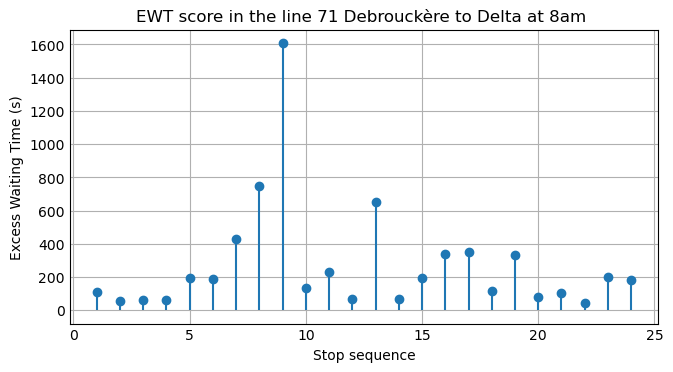

In [285]:
plt_1 = plt.figure(figsize=(6, 3))

plt.stem(ListPlotx,ListPloty,basefmt=" ")#,color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.ylabel('Excess Waiting Time (s)')
plt.xlabel('Stop sequence')
plt.title('EWT score in the line 71 Debrouckère to Delta at 8am ')

Text(0.5, 1.0, 'EWT score in the line 1 Erasme to Herrmann-Debroux at 8am ')

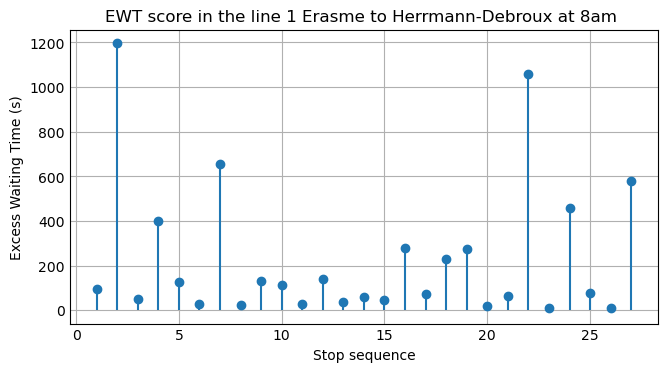

In [201]:
plt_1 = plt.figure(figsize=(6, 3))

plt.stem(ListPlotx,ListPloty,basefmt=" ")#,color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.ylabel('Excess Waiting Time (s)')
plt.xlabel('Stop sequence')
plt.title('EWT score on the line 1 Erasme to Herrmann-Debroux at 8am ')

<StemContainer object of 3 artists>

<Figure size 600x300 with 0 Axes>

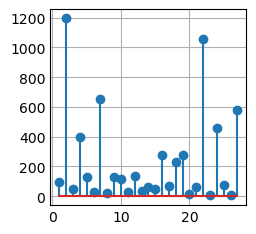

In [197]:
plt_1 = plt.figure(figsize=(6, 3))

fig, ax = plt.subplots()

ax.stem(ListPlotx,ListPloty)


 

In [168]:
ServiceSeri = pd.Series(FromDayToService(('20210917','friday')))

In [260]:
max_sequ = stop_times[(stop_times['stop_id'].isin(ListStopSeries))&(stop_times['service_id'].isin(ServiceSeri))&(stop_times['direction_id']==0)]['stop_sequence'].max()
max_sequ

21

In [265]:
stop_times[(stop_times['stop_id'].isin(ListStopSeries))&(stop_times['service_id'].isin(ServiceSeri))&(stop_times['direction_id']==0)]['trip_id'].unique()

array(['113338420237529001', '113338422237529001', '113338423237529001',
       '113338424237529001', '113338425237529001', '113338426237529001',
       '113338427237529001', '113338428237529001', '113338429237529001',
       '113338430237529001', '113338431237529001', '113338432237529001',
       '113338433237529001', '113338434237529001', '113338435237529001',
       '113338436237529001', '113338437237529001', '113338438237529001',
       '113338439237529001', '113338440237529001', '113338441237529001',
       '113338442237529001', '113338443237529001', '113338444237529001',
       '113338445237529001', '113338446237529001', '113338447237529001',
       '113338448237529001', '113338449237529001', '113338450237529001',
       '113338451237529001', '113338452237529001', '113338453237529001',
       '113338454237529001', '113338455237529001', '113338456237529001',
       '113338457237529001', '113338458237529001', '113338459237529001',
       '113338460237529001', '113338461237529001', 

In [266]:
stop_times[stop_times['trip_id']=='113070829236683000'][['stop_id','stop_sequence']]

,stop_id,stop_sequence
1442369,3521,1
1442370,3556,2
1442371,1598B,3
1442372,3557,4
1442373,3558,5
1442374,3559,6
1442375,3525,7
1442376,2351,8
1442377,3562B,9
1442378,3570,10


In [193]:
stops[stops['stop_id']=='8262']

,stop_id,stop_code,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,geometry
2508,8262,NaN,HERRMANN-DEBROUX,NaN,NaN,NaN,0,28,POINT (4.42924 50.81224)


In [261]:
stop_times[(stop_times['stop_id'].isin(ListStopSeries))&(stop_times['service_id'].isin(ServiceSeri))&(stop_times['stop_sequence']==21)]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,route_id,service_id,direction_id,shape_id,stop_code,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,geometry
1442389,113070829236683000,19320.0,19320.0,2596,21,0,0,65,236683000,1,071b0195,NaN,DE BROUCKERE,NaN,NaN,NaN,0,NaN,POINT (4.35265 50.84965)
1442429,113070831236683000,32640.0,32640.0,2596,21,0,0,65,236683000,1,071b0195,NaN,DE BROUCKERE,NaN,NaN,NaN,0,NaN,POINT (4.35265 50.84965)
1442469,113070833236683000,37920.0,37920.0,2596,21,0,0,65,236683000,1,071b0195,NaN,DE BROUCKERE,NaN,NaN,NaN,0,NaN,POINT (4.35265 50.84965)
1442490,113070834236683000,43620.0,43620.0,2596,21,0,0,65,236683000,1,071b0195,NaN,DE BROUCKERE,NaN,NaN,NaN,0,NaN,POINT (4.35265 50.84965)
1442530,113070836236683000,50100.0,50100.0,2596,21,0,0,65,236683000,1,071b0195,NaN,DE BROUCKERE,NaN,NaN,NaN,0,NaN,POINT (4.35265 50.84965)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701207,113422609238072001,97680.0,97680.0,3558,21,0,0,82,238072001,0,208b0110,NaN,CIM. D'IXELLES,NaN,NaN,NaN,0,NaN,POINT (4.39060 50.81598)
1701340,113422615238072001,92880.0,92880.0,3558,21,0,0,82,238072001,0,208b0110,NaN,CIM. D'IXELLES,NaN,NaN,NaN,0,NaN,POINT (4.39060 50.81598)
1701395,113422617238072001,96480.0,96480.0,3558,21,0,0,82,238072001,0,208b0110,NaN,CIM. D'IXELLES,NaN,NaN,NaN,0,NaN,POINT (4.39060 50.81598)
1701476,113422624238072001,98880.0,98880.0,3558,21,0,0,82,238072001,0,208b0110,NaN,CIM. D'IXELLES,NaN,NaN,NaN,0,NaN,POINT (4.39060 50.81598)


In [264]:
stops[stops['stop_id']=='2595']

,stop_id,stop_code,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,geometry
987,2595,NaN,DE BROUCKERE,NaN,NaN,NaN,0,NaN,POINT (4.35389 50.85050)


In [166]:
stop_times[stop_times['trip_id']=='112585714234578052'].head(20)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,route_id,service_id,direction_id,shape_id,stop_code,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,geometry
1710186,112585714234578052,20537.0,20537.0,8641,1,0,0,1,234578052,0,005m0077,NaN,ERASME,NaN,NaN,NaN,0,11,POINT (4.26611 50.81522)
1710187,112585714234578052,20629.0,20629.0,8652,2,0,0,1,234578052,0,005m0077,NaN,EDDY MERCKX,NaN,NaN,NaN,0,10,POINT (4.28155 50.81650)
1710188,112585714234578052,20705.0,20705.0,8662,3,0,0,1,234578052,0,005m0077,NaN,CERIA,NaN,NaN,NaN,0,9,POINT (4.29020 50.81645)
1710189,112585714234578052,20782.0,20782.0,8672,4,0,0,1,234578052,0,005m0077,NaN,LA ROUE,NaN,NaN,NaN,0,8,POINT (4.29404 50.82126)
1710190,112585714234578052,20846.0,20846.0,8682,5,0,0,1,234578052,0,005m0077,NaN,BIZET,NaN,NaN,NaN,0,7,POINT (4.29764 50.82517)
1710191,112585714234578052,20919.0,20919.0,8692,6,0,0,1,234578052,0,005m0077,NaN,VEEWEYDE,NaN,NaN,NaN,0,6,POINT (4.30073 50.82961)
1710192,112585714234578052,20999.0,20999.0,8702,7,0,0,1,234578052,0,005m0077,NaN,SAINT-GUIDON,NaN,NaN,NaN,0,5,POINT (4.30532 50.83493)
1710193,112585714234578052,21079.0,21079.0,8712,8,0,0,1,234578052,0,005m0077,NaN,AUMALE,NaN,NaN,NaN,0,4,POINT (4.31252 50.83967)
1710194,112585714234578052,21160.0,21160.0,8722,9,0,0,1,234578052,0,005m0077,NaN,JACQUES BREL,NaN,NaN,NaN,0,3,POINT (4.31817 50.84399)
1710195,112585714234578052,21232.0,21232.0,8732,10,0,0,1,234578052,0,005m0077,NaN,GARE DE L'OUEST,NaN,NaN,NaN,0,2,POINT (4.32110 50.84898)


In [ ]:
for route in MedianEWTFri['route_id'].values:
    print(len(MedianEWTWed[MedianEWTWed['route_id']==10]['stop_id'].unique()),route)

In [72]:
len(stop_times[(stop_times['route_id']=='2')]['stop_id'].unique())

60

Ici on va juste modifier légèrement les outputs de stop line pour pouvoir les mettres en data frame, c'est utile pour l'analyse de Victoria

Cellule pour mercredi 

In [9]:
ReadJSON = csv.reader(open('stop_times_line_wed.csv','r'),delimiter=',')
header = ['route_id','stop_id','ArrivalTime']

with open('stop_time_line_wed_forDF.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    for i,rowJSON in enumerate(ReadJSON):
        if len(rowJSON)>2:
            route = FromLineIdtoRouteId(rowJSON[0])
            stop = rowJSON[1]
            ArrivalTime = np.array(rowJSON[2].split(',')).astype(np.float64)
            #IntervalTime = ArrivalTime[1:]-ArrivalTime[:-1]
            for arrivalJSON in ArrivalTime:
                RowToWrite=[route,stop,arrivalJSON]
                writer.writerow(RowToWrite)
        if i%100==0:
            print(str(i)+' arrêts encodés')

0 arrêts encodés
100 arrêts encodés
200 arrêts encodés
300 arrêts encodés
400 arrêts encodés
500 arrêts encodés
600 arrêts encodés
700 arrêts encodés
800 arrêts encodés
900 arrêts encodés
1000 arrêts encodés
1100 arrêts encodés
1200 arrêts encodés
1300 arrêts encodés
1400 arrêts encodés
1500 arrêts encodés
1600 arrêts encodés
1700 arrêts encodés
1800 arrêts encodés
1900 arrêts encodés
2000 arrêts encodés
2100 arrêts encodés
2200 arrêts encodés


Cellule pour vendredi

In [10]:
ReadJSON = csv.reader(open('stop_times_line_fri.csv','r'),delimiter=',')
header = ['route_id','stop_id','ArrivalTime']

with open('stop_time_line_fri_forDF.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    for i,rowJSON in enumerate(ReadJSON):
        if len(rowJSON)>2:
            route = FromLineIdtoRouteId(rowJSON[0])
            stop = rowJSON[1]
            ArrivalTime = np.array(rowJSON[2].split(',')).astype(np.float64)
            #IntervalTime = ArrivalTime[1:]-ArrivalTime[:-1]
            for arrivalJSON in ArrivalTime:
                RowToWrite=[route,stop,arrivalJSON]
                writer.writerow(RowToWrite)
        if i%500==0:
            print(str(i)+' arrêts encodés')

0 arrêts encodés
500 arrêts encodés
1000 arrêts encodés
1500 arrêts encodés
2000 arrêts encodés
2500 arrêts encodés


Cellule pour samedi

In [11]:
ReadJSON = csv.reader(open('stop_times_line_sat.csv','r'),delimiter=',')
header = ['route_id','stop_id','ArrivalTime']

with open('stop_time_line_sat_forDF.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    for i,rowJSON in enumerate(ReadJSON):
        if len(rowJSON)>2:
            route = FromLineIdtoRouteId(rowJSON[0])
            stop = rowJSON[1]
            ArrivalTime = np.array(rowJSON[2].split(',')).astype(np.float64)
            #IntervalTime = ArrivalTime[1:]-ArrivalTime[:-1]
            for arrivalJSON in ArrivalTime:
                RowToWrite=[route,stop,arrivalJSON]
                writer.writerow(RowToWrite)
        if i%500==0:
            print(str(i)+' arrêts encodés')

0 arrêts encodés
500 arrêts encodés
1000 arrêts encodés
1500 arrêts encodés
2000 arrêts encodés
2500 arrêts encodés


Cellule pour dimanche

In [12]:
ReadJSON = csv.reader(open('stop_times_line_sun.csv','r'),delimiter=',')
header = ['route_id','stop_id','ArrivalTime']

with open('stop_time_line_sun_forDF.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    for i,rowJSON in enumerate(ReadJSON):
        if len(rowJSON)>2:
            route = FromLineIdtoRouteId(rowJSON[0])
            stop = rowJSON[1]
            ArrivalTime = np.array(rowJSON[2].split(',')).astype(np.float64)
            #IntervalTime = ArrivalTime[1:]-ArrivalTime[:-1]
            for arrivalJSON in ArrivalTime:
                RowToWrite=[route,stop,arrivalJSON]
                writer.writerow(RowToWrite)
        if i%500==0:
            print(str(i)+' arrêts encodés')

0 arrêts encodés
500 arrêts encodés
1000 arrêts encodés
1500 arrêts encodés
2000 arrêts encodés
2500 arrêts encodés


In [84]:
SchedulePuncdf = pd.read_csv('SchedulePunc20210915.csv')
JSONArrival = pd.read_csv('stop_time_line_cleared2_forDF.csv')
JSONArrival[(JSONArrival['stop_id']=='2')&(JSONArrival['route_id']==8161)]
JSONArrival['stop_id'].unique()

array([8011, 8012, 8021, ..., 5964, 9649, 9686], dtype=int64)

On peut mtn créer les fichier JSON de ponctualités avec les différences !

Cellule pour mecredi

In [14]:
#Fonction Vic ponctualité

SchedulePuncdf = pd.read_csv('Schedule20210915.csv')
JSONArrival = pd.read_csv('stop_time_line_wed_forDF.csv')

#ReadSchedule = csv.reader(open('SchedulePunc20210915.csv', 'r'),delimiter=',')
#ReadJSON = csv.reader(open('stop_times_line_cleared2.csv','r'),delimiter=',')


header = ['route_id','stop_id','ArrivalTime','Difference']

with open('PunctualityExploreWed.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    l=0
    for route in DicOfStopInRoute:
        for stop in DicOfStopInRoute[route]:
            if stop.isnumeric():
                SchedulePuncdfForStop = SchedulePuncdf[(SchedulePuncdf['route_id']==int(route)) & (SchedulePuncdf['stop_id']==str(stop))]
                if len(SchedulePuncdfForStop)>0:
                    JSONArrivaldfForStop = JSONArrival[(JSONArrival['stop_id']==int(stop))&(JSONArrival['route_id']==int(route))]
                    if len(JSONArrivaldfForStop)>0:
                        ArrivalTime = JSONArrivaldfForStop['ArrivalTime'].values
                        for arrival in ArrivalTime:
                                closest = min(SchedulePuncdfForStop['ArrivalTime'].values,key=lambda x: abs(x-arrival))
                                difference = arrival-closest
                                RowToWrite=[route,stop,arrival,difference]
                                writer.writerow(RowToWrite)
                            
        l+=1
        if l%10==0:
            print(str(l)+' routes encodés')
                

10 arrêts encodés
20 arrêts encodés
30 arrêts encodés
40 arrêts encodés
50 arrêts encodés
60 arrêts encodés
70 arrêts encodés
80 arrêts encodés
90 arrêts encodés


In [23]:
MeasurePunc = pd.read_csv('PunctualityExplore.csv')
MeasurePunc[MeasurePunc['route_id']==40].head()

,route_id,stop_id,ArrivalTime,Difference
51177,40,5501,22400.964,18.964
51178,40,5501,23400.621,58.621
51179,40,5501,24589.724,-48.276
51180,40,5501,25129.592,47.592
51181,40,5501,25847.846,45.846


Cellule pour vendredi

In [20]:
#Fonction Vic ponctualité

SchedulePuncdf = pd.read_csv('Schedule20210917.csv')
JSONArrival = pd.read_csv('stop_time_line_fri_forDF.csv')

#ReadSchedule = csv.reader(open('SchedulePunc20210915.csv', 'r'),delimiter=',')
#ReadJSON = csv.reader(open('stop_times_line_cleared2.csv','r'),delimiter=',')


header = ['route_id','stop_id','ArrivalTime','Difference']

with open('PunctualityExploreFri.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    l=0
    for route in DicOfStopInRoute:
        for stop in DicOfStopInRoute[route]:
            if stop.isnumeric():
                SchedulePuncdfForStop = SchedulePuncdf[(SchedulePuncdf['route_id']==int(route)) & (SchedulePuncdf['stop_id']==str(stop))]
                if len(SchedulePuncdfForStop)>0:
                    JSONArrivaldfForStop = JSONArrival[(JSONArrival['stop_id']==int(stop))&(JSONArrival['route_id']==int(route))]
                    if len(JSONArrivaldfForStop)>0:
                        ArrivalTime = JSONArrivaldfForStop['ArrivalTime'].values
                        for arrival in ArrivalTime:
                                closest = min(SchedulePuncdfForStop['ArrivalTime'].values,key=lambda x: abs(x-arrival))
                                difference = arrival-closest
                                RowToWrite=[route,stop,arrival,difference]
                                writer.writerow(RowToWrite)
                            
        l+=1
        if l%10==0:
            print(str(l)+' routes encodés')
                

10 routes encodés
20 routes encodés
30 routes encodés
40 routes encodés
50 routes encodés
60 routes encodés
70 routes encodés
80 routes encodés
90 routes encodés


Cellule pour samedi

In [19]:
#Fonction Vic ponctualité

SchedulePuncdf = pd.read_csv('Schedule20210918.csv')
JSONArrival = pd.read_csv('stop_time_line_sat_forDF.csv')

#ReadSchedule = csv.reader(open('SchedulePunc20210915.csv', 'r'),delimiter=',')
#ReadJSON = csv.reader(open('stop_times_line_cleared2.csv','r'),delimiter=',')


header = ['route_id','stop_id','ArrivalTime','Difference']

with open('PunctualityExploreSat.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    l=0
    for route in DicOfStopInRoute:
        for stop in DicOfStopInRoute[route]:
            if stop.isnumeric():
                SchedulePuncdfForStop = SchedulePuncdf[(SchedulePuncdf['route_id']==int(route)) & (SchedulePuncdf['stop_id']==str(stop))]
                if len(SchedulePuncdfForStop)>0:
                    JSONArrivaldfForStop = JSONArrival[(JSONArrival['stop_id']==int(stop))&(JSONArrival['route_id']==int(route))]
                    if len(JSONArrivaldfForStop)>0:
                        ArrivalTime = JSONArrivaldfForStop['ArrivalTime'].values
                        for arrival in ArrivalTime:
                                closest = min(SchedulePuncdfForStop['ArrivalTime'].values,key=lambda x: abs(x-arrival))
                                difference = arrival-closest
                                RowToWrite=[route,stop,arrival,difference]
                                writer.writerow(RowToWrite)
                            
        l+=1
        if l%10==0:
            print(str(l)+' routes encodés')
                

10 routes encodés
20 routes encodés
30 routes encodés
40 routes encodés
50 routes encodés
60 routes encodés
70 routes encodés
80 routes encodés
90 routes encodés


Cellule pour dimanche

In [17]:
#Fonction Vic ponctualité

SchedulePuncdf = pd.read_csv('Schedule20210919.csv')
JSONArrival = pd.read_csv('stop_time_line_sun_forDF.csv')

#ReadSchedule = csv.reader(open('SchedulePunc20210915.csv', 'r'),delimiter=',')
#ReadJSON = csv.reader(open('stop_times_line_cleared2.csv','r'),delimiter=',')


header = ['route_id','stop_id','ArrivalTime','Difference']

with open('PunctualityExploreSun.csv', 'w', encoding='UTF8',newline='') as file:
    writer = csv.writer(file)
    # write the header
    writer.writerow(header)
    l=0
    for route in DicOfStopInRoute:
        for stop in DicOfStopInRoute[route]:
            if stop.isnumeric():
                SchedulePuncdfForStop = SchedulePuncdf[(SchedulePuncdf['route_id']==int(route)) & (SchedulePuncdf['stop_id']==str(stop))]
                if len(SchedulePuncdfForStop)>0:
                    JSONArrivaldfForStop = JSONArrival[(JSONArrival['stop_id']==int(stop))&(JSONArrival['route_id']==int(route))]
                    if len(JSONArrivaldfForStop)>0:
                        ArrivalTime = JSONArrivaldfForStop['ArrivalTime'].values
                        for arrival in ArrivalTime:
                                closest = min(SchedulePuncdfForStop['ArrivalTime'].values,key=lambda x: abs(x-arrival))
                                difference = arrival-closest
                                RowToWrite=[route,stop,arrival,difference]
                                writer.writerow(RowToWrite)
                            
        l+=1
        if l%10==0:
            print(str(l)+' routes encodés')
                

10 routes encodés
20 routes encodés
30 routes encodés
40 routes encodés
50 routes encodés
60 routes encodés
70 routes encodés
80 routes encodés
90 routes encodés


In [18]:
MeasurePunc = pd.read_csv('PunctualityExploreSun.csv')
MeasurePunc[MeasurePunc['route_id']==40].head()

,route_id,stop_id,ArrivalTime,Difference
55829,40,5501,21079.163,17.163
55830,40,5501,22865.202,3.202
55831,40,5501,27080.983,18.983
55832,40,5501,29493.056,31.056
55833,40,5501,30698.942,36.942
